### **Digital Bookshelf Try #1: Traditional Computer Vision Approach**

I want to build a end-to-end tool that will allow me to take a picture of a bookshelf and get a list of books/authors. After a literature search, there have been some somewhat succesfull models. None of these algorithms are accurate/precise/fast enough for what I want though! 

To get an idea of the difficulties of the task, I will first look at how well a traditional CV approach can do. First, a few required imports.

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import os 

#### Approach

Our first approach will use some 'traditional' (pre-deep learning) image processing techniques. In order, I will first

1. Gray scale the image
2. Apply a Canny edge detector
3. Apply a linear Hough transform (or probabilistic hough transform, if it works better) to delineate the books
4. Finally, step through lines and assign the pairs to books


I am going to start with a sample image small bookshelf (I pulled this from Twitter under <span style="color:blue">#bookshelf</span>). I then apply grayscale to the image.


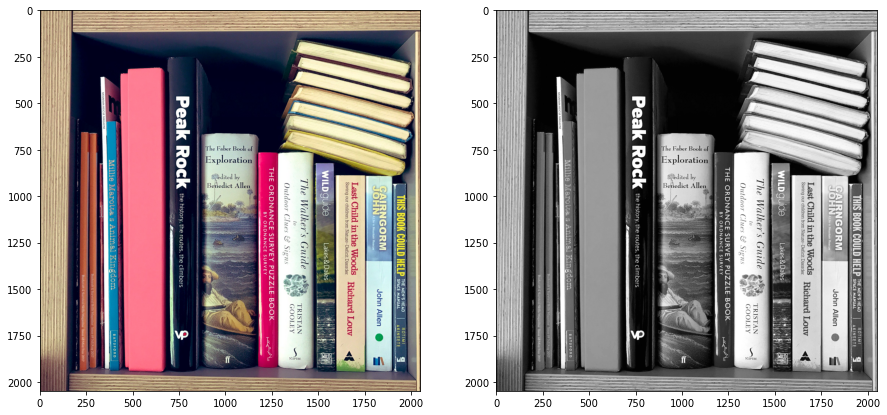

In [2]:
os.chdir('..')
img = io.imread('bookshelfs_unlabelled/0004.jpg')
os.chdir('notebooks/')

from skimage.color import rgb2gray
grayscale = rgb2gray(img)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
axes[0].imshow(img)
axes[1].imshow(grayscale, cmap="gray")
plt.show()

Next, I apply a Canny edge detector to find the edges in the image. Canny edge detection is [pretty straight forward](https://en.wikipedia.org/wiki/Canny_edge_detector#Process_of_Canny_edge_detection_algorithm). It essentially involves 
1. A Gaussian filter to reduce the noise in the image.
2. Finding the gradients of the image with the Sobel operator.
3. Finding the maximum of these gradients (i.e. non-maximum suppression).
4. Thresholding and finding continuous edges by hysteresis.

To save time and sanity, I use scikit-image to apply the edge detection.

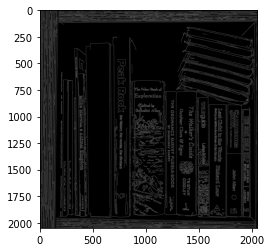

In [3]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny


edges = canny(grayscale, sigma=2.0)
plt.imshow(edges, cmap="gray")
plt.show()

Finally, I try to apply a [linear hough transform](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/HoughTrans_lines_09.pdf) to find the 'lines' that pick out the two edges we expect each book to have in an image. A Hough transform maps a cartesian image space to a polar Hough parameter space. That is, we parameterize lines with 

$x \cos \theta+y \sin \theta=r$,

and plot candidate $(r, \theta)$ in the Hough space (as sinusoidal curves) as defined by all of the $(x_i, y_i)$ in the image space. It's worth noting that this is a one-to-many mapping.

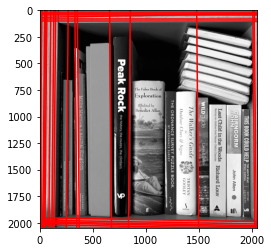

In [4]:
import numpy as np

h, theta, d = hough_line(edges)
row1, col1, _ = img.shape

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col1 * np.cos(angle)) / np.sin(angle)
    plt.plot((0, col1), (y0, y1), '-r')
    
plt.axis((0, col1, row1, 0))

plt.imshow(grayscale, cmap="gray")
plt.show()

I also try a [probabilistic hough transform](http://cmp.felk.cvut.cz/~matas/papers/matas-bmvc98.pdf) for good measure.

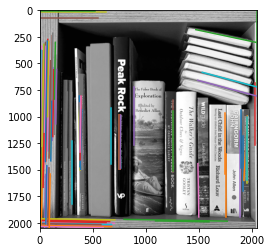

In [5]:
lines = probabilistic_hough_line(edges, threshold=100, line_length=500,
                                 line_gap=25)
    
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))


plt.imshow(grayscale, cmap="gray")
plt.show()

I played around with the `sigma` parameter in the Canny filter quite a bit and can't find a good medium between picking out _way_ too many lines or too few lines for this image. 

### Trying with another image

After doing a brief literature search/some googling, I found some essentially similar approaches that have [had some success](https://ieeexplore.ieee.org/document/8941541). 

The differentiating factor between these approaches and my approach? They all tend to use _very_ easy images of bookshelfs. In the images, all of the books are basically vertical and most have high-contrast, easily segmentable, spines. Here, I try the same pipeline I used above with my book shelf that I arranged to have these characteristics. 

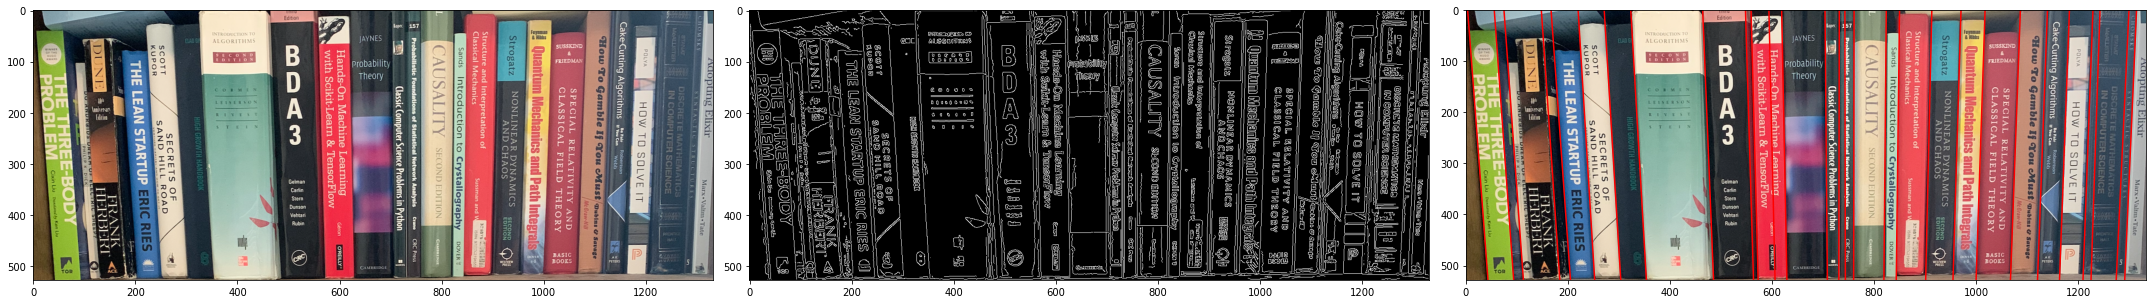

In [6]:
os.chdir('..')
# img2 = io.imread('bookshelfs_unlabelled/0001.jpg')[:,:,:3]
img2 = io.imread('bookshelfs_unlabelled/mybookshelf.png')[:,:,:3]
os.chdir('notebooks/')
figure, axes = plt.subplots(nrows=1, ncols=3,figsize=(30,30))

axes[0].imshow(img2)
# plt.imshow(img2)
# plt.show()

grayscale2 = rgb2gray(img2)
edges2 = canny(grayscale2, sigma=1)
# plt.imshow(edges2, cmap="gray")
# plt.show()
axes[1].imshow(edges2, cmap="gray")

angle_search = np.linspace(-np.pi / 5, np.pi / 5, 360)
h2, theta2, d2 = hough_line(edges2, theta= angle_search)
row2, col2, _ = img2.shape

line_list = []
for _, angle2, dist2 in zip(*hough_line_peaks(h2, theta2, d2)):
    y0 = (dist2 - 0 * np.cos(angle2)) / np.sin(angle2)
    y1 = (dist2 - col2 * np.cos(angle2)) / np.sin(angle2)
    line_list.append((y0, y1))
    plt.plot((0, col2), (y0, y1), '-r')
axes[2].axis([0, col2, row2, 0])

axes[2].imshow(img2, cmap="gray")
# plt.show()

figure.tight_layout()


It is a bit easier to see how accurate the method is when we slice the images and check them out individually. Rather than defining a careful method to check e.g. whether the lines are at similar angles, etc. I am only going to check if the lines are reasonably space (ie do not bracket the entire image).

In [7]:
# define methods to find where the points where the lines from the hough transform 
# are at the vertical edges of the images
import cv2
def perp(a) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

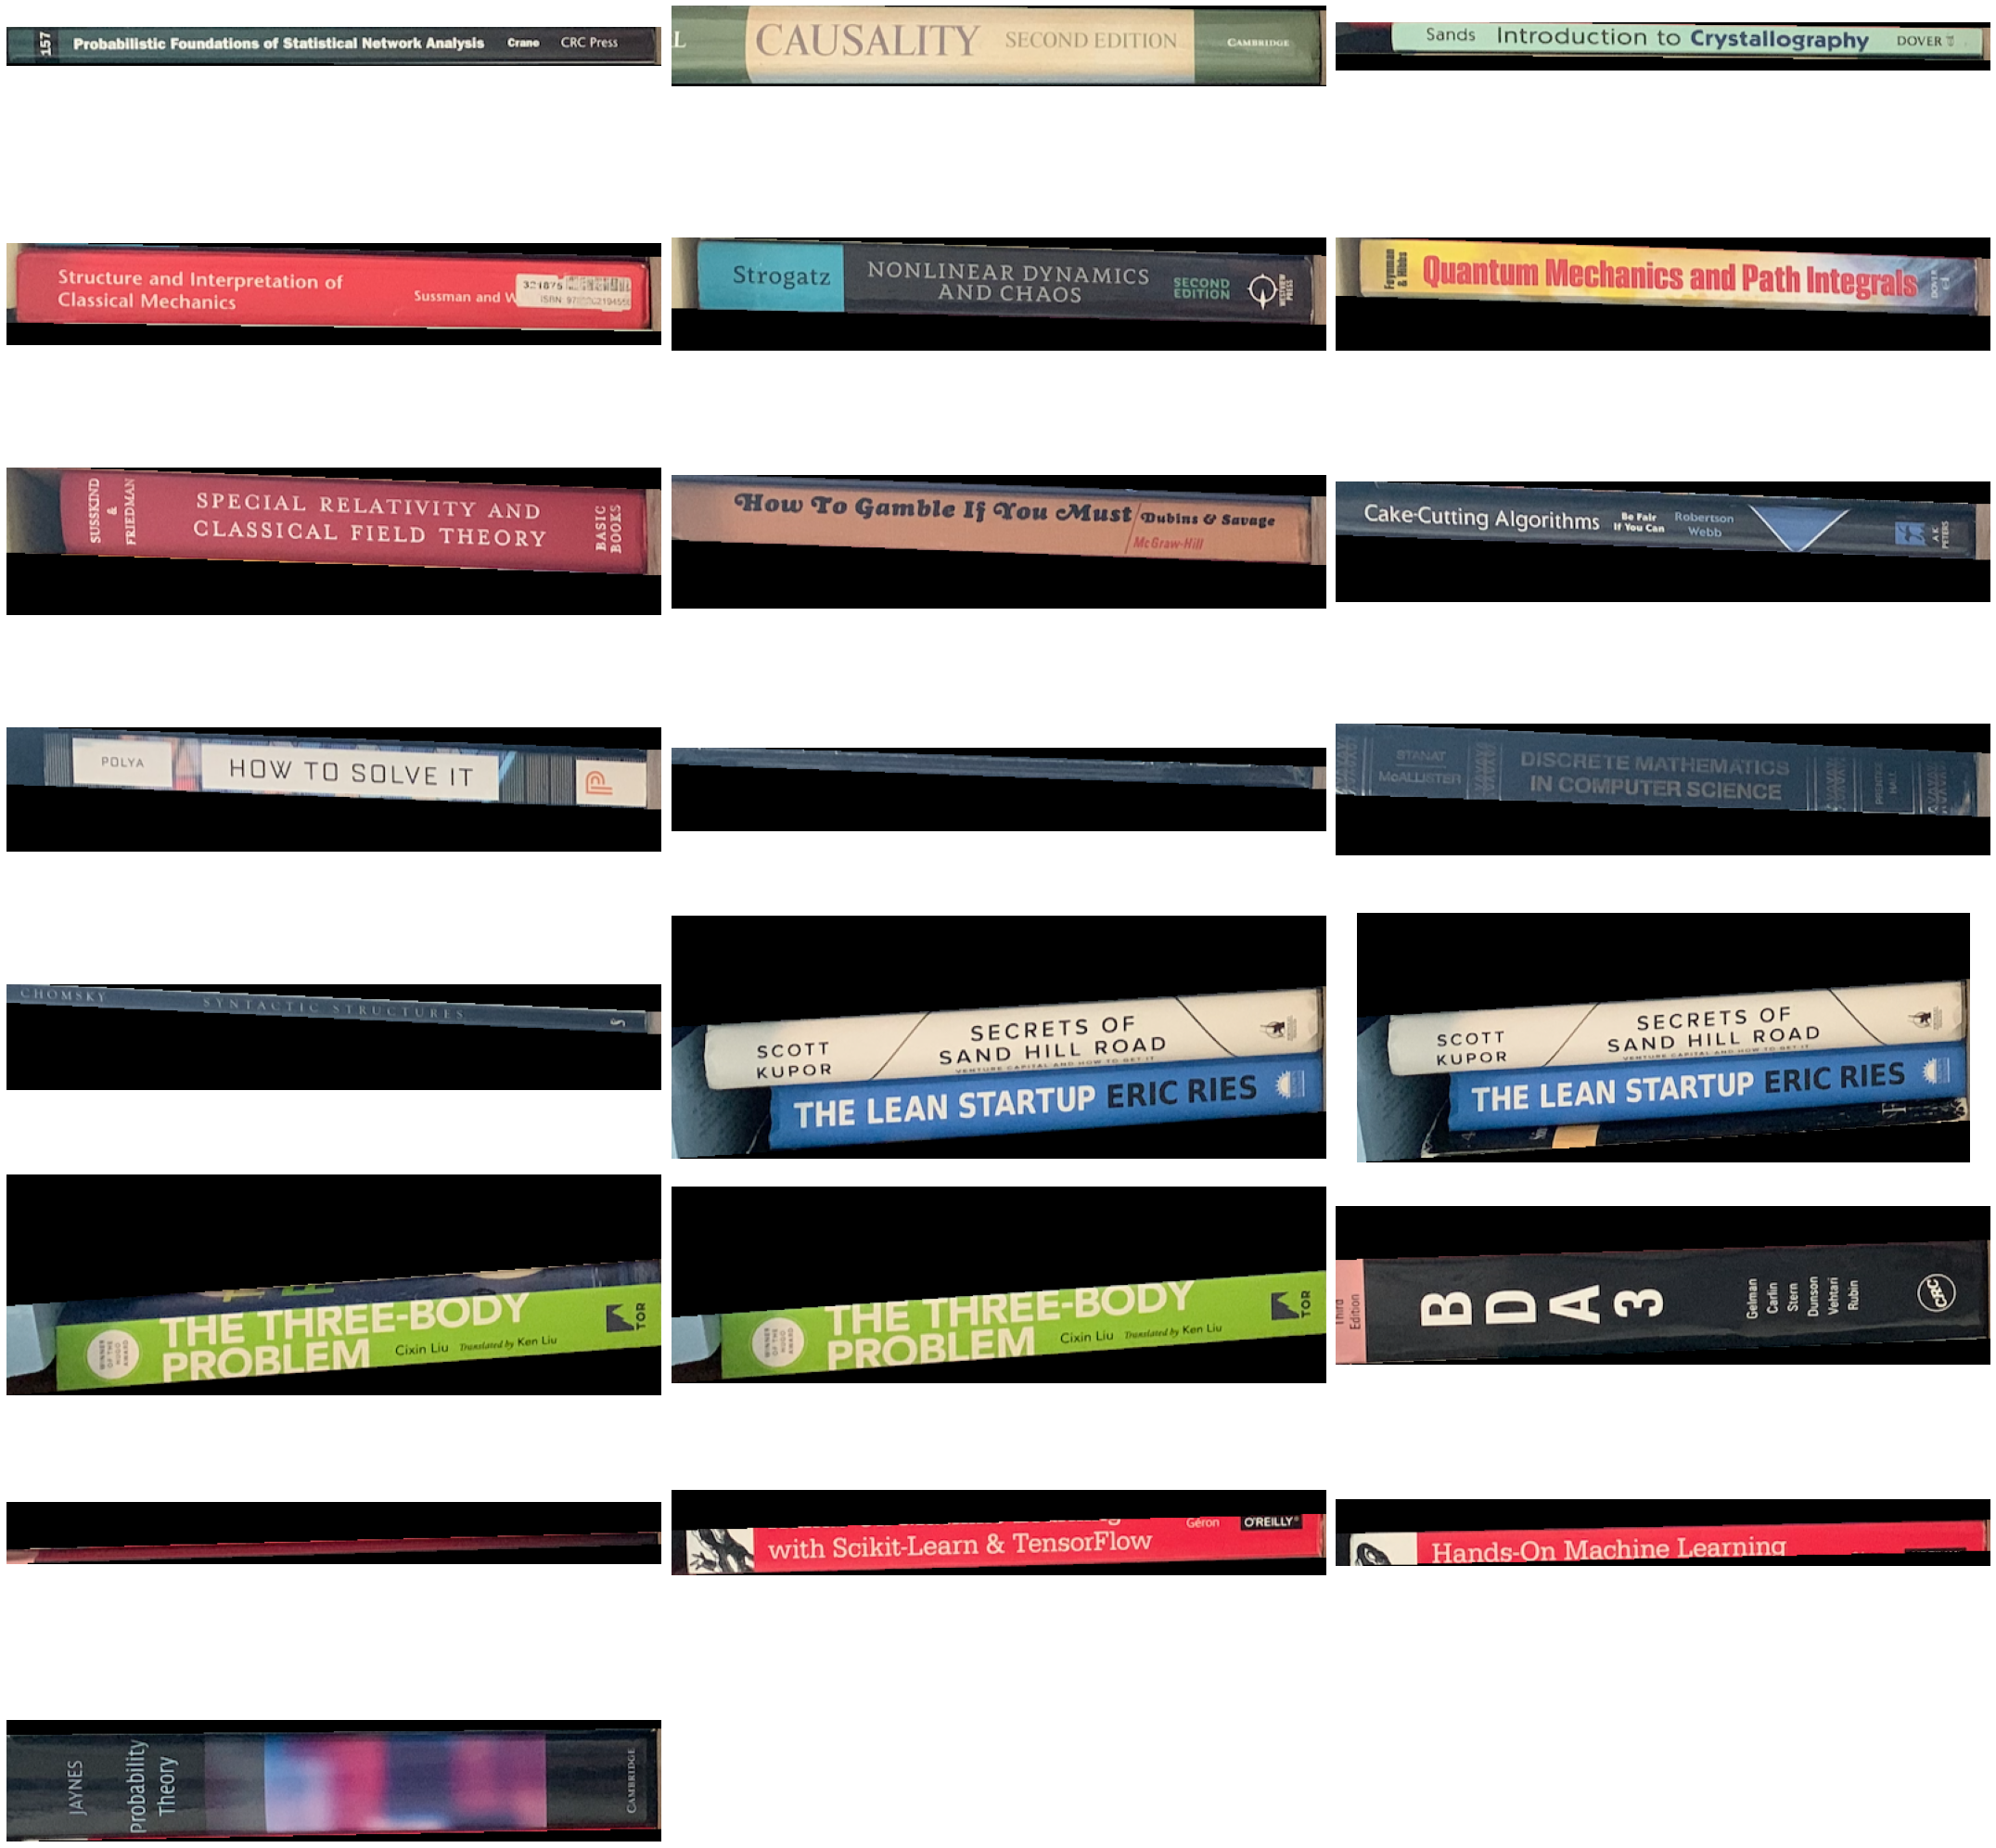

In [8]:
#sort line list in order of books in shelf
line_list = sorted(line_list, key=lambda x: x[1])
# figure, axes = plt.subplots(nrows=int(np.ceil(len(line_list)/3)), ncols=3,figsize=(30,30))
figure, axes = plt.subplots(nrows=8, ncols=3,figsize=(30,30))

os.chdir('../filteredbooks_CV/')
# iterate through lines, and slice individual books 
col, row = 0,0
for index in range(len(line_list)-1):
    
    # define points for first line
    y0_0, y1_0 = line_list[index]
    p1_0, p2_0 = np.array([0, y0_0]), np.array([col2, y1_0])
    
    p3_top, p4_top = np.array( [0,0] ), np.array( [2048,0] )
    p3_bottom, p4_bottom = np.array( [0,1486] ), np.array( [2048,1486] )
    
    # find intersection points of the first line with the image
    top_0 = (seg_intersect( p1_0,p2_0, p3_top,p4_top)[0])
    bottom_0 = (seg_intersect( p1_0,p2_0, p3_bottom,p4_bottom)[0])
    
    # define points for second line
    y0_1, y1_1 = line_list[index+1]
    p1_1, p2_1 = np.array( [0, y0_1] ), np.array( [col2, y1_1] )
    
    # find intersection points of the second line with the image
    top_1 = (seg_intersect( p1_1,p2_1, p3_top,p4_top)[0])
    bottom_1 = (seg_intersect( p1_1,p2_1, p3_bottom,p4_bottom)[0])
    
    if abs(top_1-top_0) < 160:
        
        #define mask of image
        mask = np.zeros(img2.shape, dtype=np.uint8)
        #corners to slice 
        roi_corners = np.array([[top_0, 0.0],[bottom_0,1486],[bottom_1,1486],[top_1 , 0.0]], dtype=np.int32)

        # fill ROI 
        channel_count = img2.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,)*channel_count
        cv2.fillConvexPoly(mask, roi_corners, ignore_mask_color)

        # apply the mask
        masked_image = cv2.bitwise_and(img2, mask)
        minval = int(np.min([top_0, bottom_0, bottom_1, top_1]))
        maxval = int(np.max([top_0, bottom_0, bottom_1, top_1]))
        rotated = np.rot90(masked_image[:, minval:maxval,:])
        axes[row, col].imshow(rotated)
        axes[row, col].axis('off')
        cv2.imwrite(f'{row}_{col}.jpg', cv2.cvtColor(rotated, cv2.COLOR_RGB2BGR))

        # column/row logic for sub-plots
        if col == 2:
            row += 1
            col = 0
        else:
            col += 1

        #save image to use later
#delete the final two empty axes
figure.delaxes(axes.flatten()[-1])
figure.delaxes(axes.flatten()[-2])
#plot all books
figure.tight_layout()

This approach does better for the reasons listed above, and also because I could define a smaller set of angles for which to apply the linear Hough transform. I could "brute force" the correct titles/authors of the books by applying an OCR system to a cropped image defined by every set of neighboring pairs (or maybe pairs out of triplets) of lines. 

However, there is still a lot to be desired. Even with this very easy image, the method gets fooled by a few creases. 
### Getting book titles from the images
So far I have done all of this without deep learning. However, in 2020 it'd probably be delusion to use an OCR without deep learning. In the spirit of low effort, I'll use Google's Tesseract OCR. I am going to use the python wrapper Python-tesseract. 

In [9]:
import pytesseract

The pre-processing step(s) below is redundant from the steps above. I decide to include it separately to make it easier (i.e. more explicit) to include in later steps of my digital bookshelf project where I will use different methods that will not include classic computer vision pre-processing. I first define a method to deskew the image (arrange it so the text is horizontal) using OpenCV.

In [10]:
# I found that OpenCV warpAffine was much faster than scikit-image's 
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

Finally, I apply pre-processing and OCR on the books. I plot the books out below, where the title of the plot is the OCR attempt of reading the text on the book. 

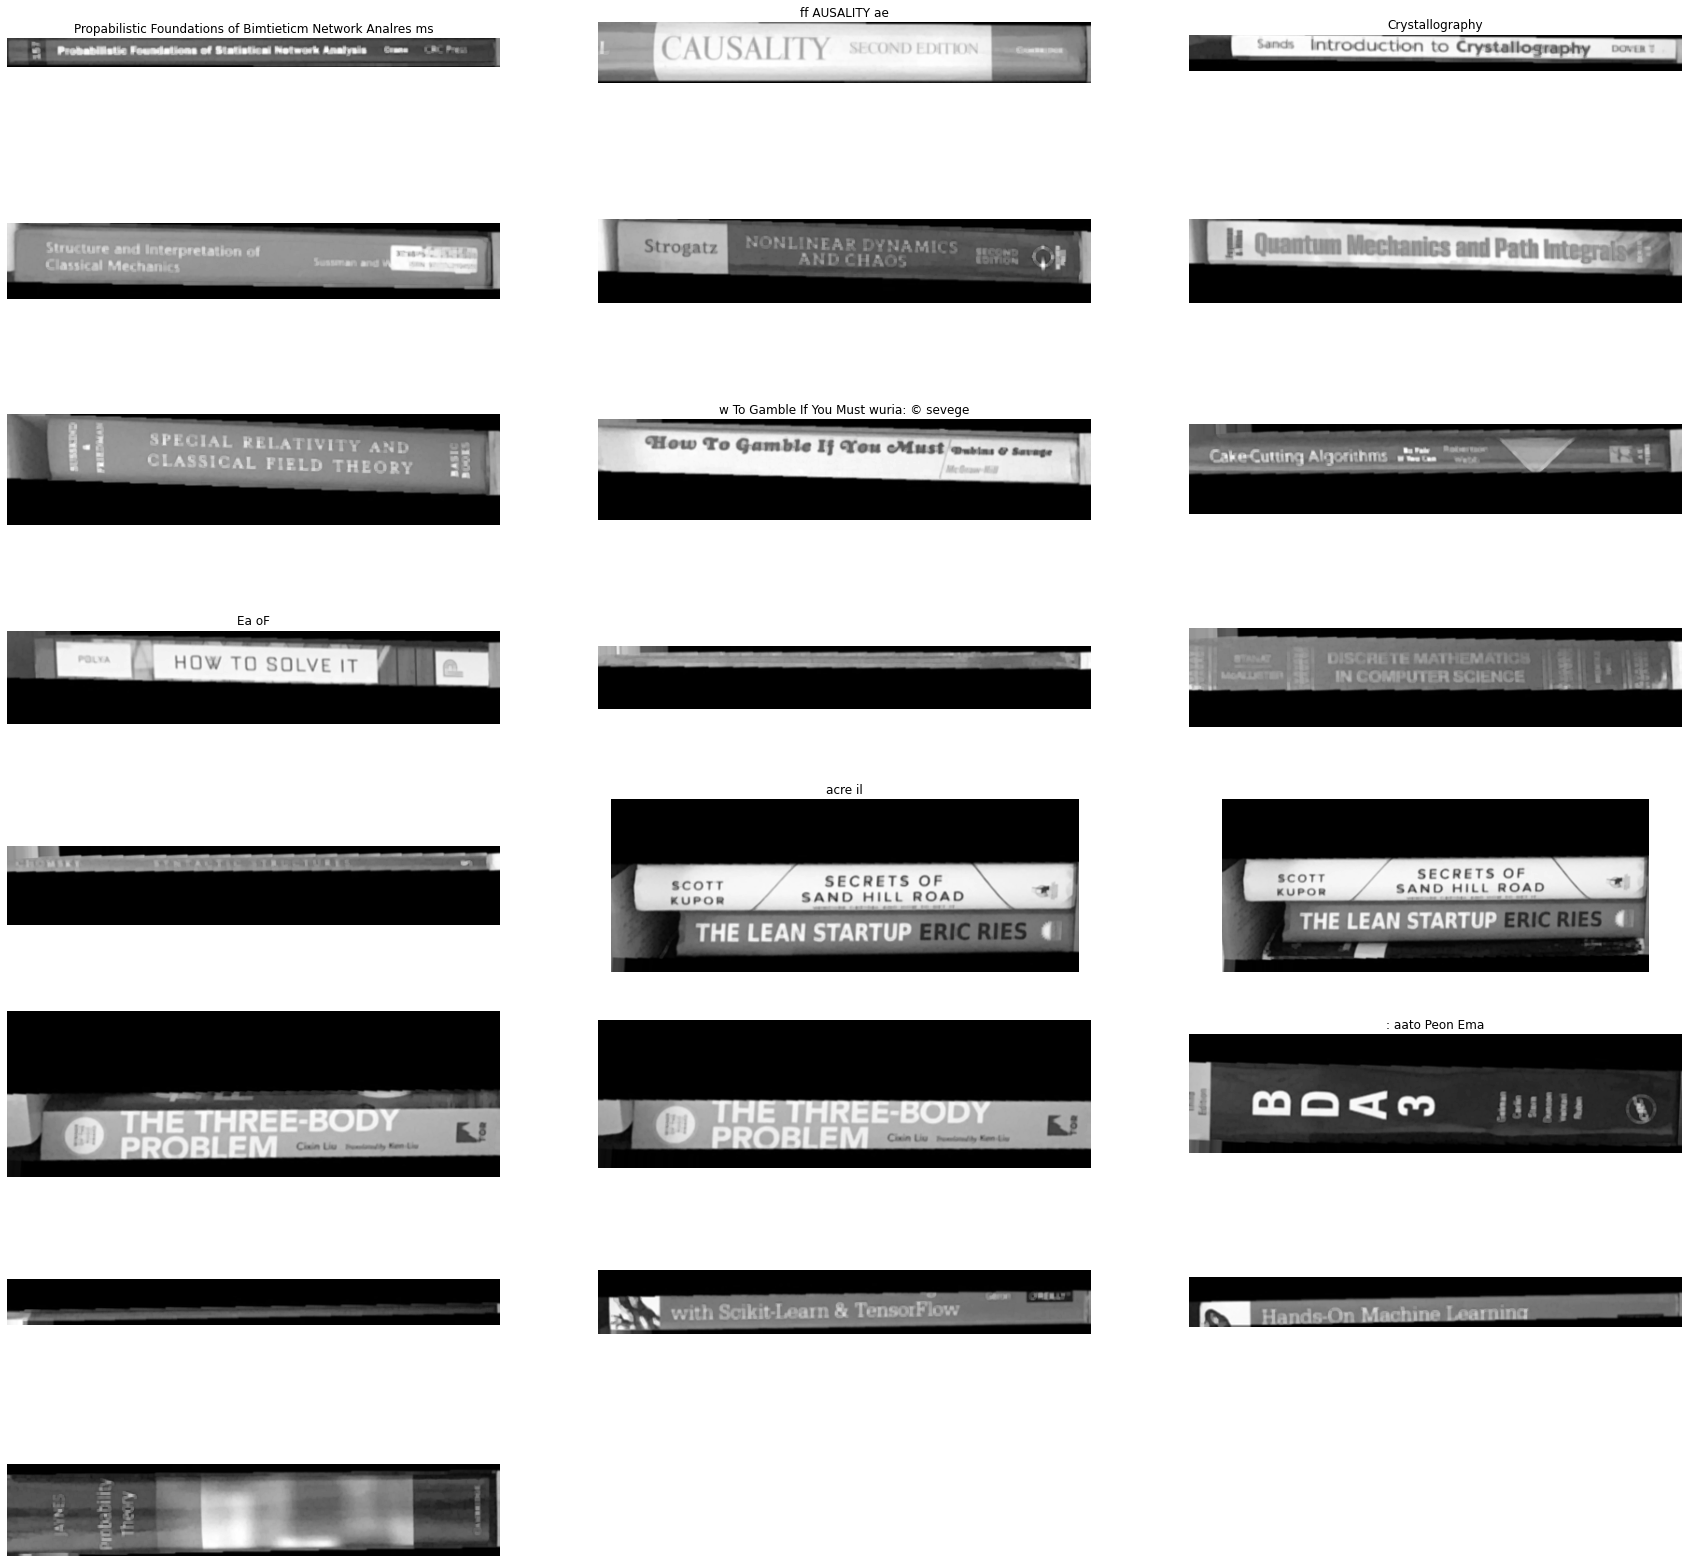

In [11]:
# figure, axes = plt.subplots(nrows=int(np.ceil(len(line_list)/3)), ncols=3,figsize=(30,30))
figure, axes = plt.subplots(nrows=8, ncols=3,figsize=(30,30))
col, row = 0,0
for index in range(24):
#     row = int(np.floor(index/3))
#     col = int(index%3)
    # read image
    image = cv2.imread(f'{row}_{col}.jpg')
    # pre-process
    blur = cv2.GaussianBlur(image, (3,3), 0)
    morph = cv2.morphologyEx(blur, cv2.MORPH_OPEN, np.ones((3,3),np.uint8)) 
    gray = cv2.cvtColor(morph, cv2.COLOR_BGR2GRAY)
    final = deskew(gray)
    
    # plot final
    axes[row, col].imshow(final, cmap="gray")
    axes[row, col].axis('off')
    plt.axis('off')

    # OCR text extraction
    custom_config = r'-l eng'
    data = pytesseract.image_to_string(final, config=custom_config)
    axes[row, col].set_title(data)
    
    # column/row logic for sub-plots
    if col == 2:
        row += 1
        col = 0
    else:
        col += 1

    
#delete the final two empty axes
figure.delaxes(axes.flatten()[-1])
figure.delaxes(axes.flatten()[-2])

The results are definetely not ideal. I tried a few different image pre-processing methods and combinations of methods (including canny filtering, erosion, dilation, thresholding, Gaussian blur, median blur) and found that they all under-performed using gray scale, de-noising, and de-skewing the image. 

There are a few approaches I could do to up the performance:
1. Find the font type used for the books and plug it into Tesseract
2. Mess with the parameters of the pre-processing (Gaussian kernel, other edge detection, etc.)
3. Mess with the parameters of Tesseract (use the RNN vs LSTM model, etc.)
3. Work with regular expressions to clean up the data output
4. Try a bundle of different methods for each image, and conditionally find the best output

However, because of the poor performance, I am going to bench the traditional approach here. Fortunately, some of the methods and considerations will probably help me out as I approach this project with a deep learning approach. 